# Modeling with Gridsearch in Google Colab

This notebook is supplementary to the primary notebook in my nlp-sentiment repo. The primary notebook performs scrubbing and exploration, and exported the results to file.

To run tasks in parallel and expediate gridsearching, I ran this notebook in Google Colab after importing the preprocessed data. Best models determined from gridsearching were exported to Google Drive. Further evaluation of the best model parameters, tweaks to the models, interpretation, and conclusions can be found in the primary notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import html
import string
import joblib

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer, word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
pd.set_option("display.max_colwidth",150)

In [3]:
# connect to Google Drive instance. 
#Note: this must be rerun each time a new Colab session is established!
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# test exporting a file to google drive to make sure it works
#test = "this is a test"
#drive_path = "/content/gdrive/My Drive/Data Science/Phase 4 Project/"
#joblib.dump(test, f"{drive_path}{test}.joblib.txt")

## Import data uploaded from local

In [4]:
# scrubbed dataframe had been dumped to file, and uploaded to git repo
# wasn't able to get the right link to load, so uploaded directly to colab
# Files must be re-uploaded with each Colab session
df = joblib.load("scrubbed_df.joblib.gz")
df.head()

,index,tweet_text,product,emotion,cleaned
0,0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,".@wesley83 I have a 3G iPhone. After hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW."
1,1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"
2,2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,@swonderlin Can not wait for #iPad also. They should sale them down at #SXSW.
3,3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
4,4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)"


In [5]:
# import stopwords lists which were generated in primary notebook.
stop_list = ["custom_stopwords", "nltk_stopwords", "punc_custom", 
             "product_stopwords"]

for stop in stop_list:
    vars()[stop] = joblib.load(f"{stop}.joblib.gz")

print(custom_stopwords[:3])
print(nltk_stopwords[:3])
print(punc_custom[:3])
print(product_stopwords[:3])

['a', 'an', 'and']
['a', 'about', 'above']
['"', '#', '$']
['google', 'apple', 'ipad']


# Binary Models for Emotion Only

First, I explore models focused only on the tweets that were labeled as having negative or positive emotions about a product or brand, leaving out the ones labeled as having no emotion towards a product or brand.

I wanted to explore the different options for vectorizing and preprocessing the text on a smaller dataset and with a simpler problem before expanding to a multi-class problem with more data, which will take longer to gridsearch and tune.

This binary classifier will also serve as a baseline for the multi-class problem where I will try to predict Positive, Negative, and No sentiment towards a product or brand. I do want to be able to weed out the tweets which are positive and negative towards a brand from those with no emotion towards a brand, but I'm not sure how well a multi-class model will be able to distinguish between all three. Having looked at the tweets themselves, the distinctions are pretty fine grains, and even I disagree with some of the labels which have been assigned. It might be a better approach to use one model to weed out the tweets which don't have a positive or negative emotion towards a brand, then run the remaining tweets through a second model to separate positive from negative.

A few of the options I'd like to try:

- Different versions of stopwords and punctuation removal. All stopwords from the default NLTK list, which I think may contain some words that will be useful, and then also my customized, pared down stopwords list. I also have the separate product stop words list which contains the terms related to the brands and products themselves, which I want to experiment with removing.


- A few different ways to vectorize and generate the frequencies in my Document Term Matrix. Regular `CountVectorizer` with the actual counts, TFIdF normalized frequencies, and also a binary frequency. The [sklearn documentation mentions](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):
>"...very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable."


- Unigrams, uni- and bigrams, and just bigrams.

Some initial constants:

- I've decided to use just one set of punctuation to be removed, where I will remove everything except `?`, `!`, and `...`.

- I will experiment stemming and lemmatization, but will start without them first.

 
I'll use the `TweetTokenizer` from NLTK to perform the tokenization, since it has the option to remove handled, which I would like to do. To enable experimenting with stemming and lemmatization in a gridsearch, I'll create a custom function which uses the TweetTokenizer, and pass to the `tokenizer` step of the sklearn `CountVectorizer` so I can change it up.

## Preprocessing for binary modeling

In [13]:
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [6]:
# create X and y based on just the positive and negative emotions
X = df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion']), 
           'cleaned']
y = df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion']), 
           'emotion']

In [7]:
# convert class labels to binary
y = y.map(lambda x: 1 if x=="Negative emotion" else 0)
y.value_counts()

0    2978
1     570
Name: emotion, dtype: int64

In [8]:
# Save label translation for later: 1 is negative, 0 is positive
class_labels = ['Positive', 'Negative']

In [9]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                               stratify=y)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2838
2838
710
710


In [10]:
y_train.value_counts(normalize=True)

0    0.839323
1    0.160677
Name: emotion, dtype: float64

In [11]:
y_test.value_counts(normalize=True)

0    0.839437
1    0.160563
Name: emotion, dtype: float64

In [12]:
def eval_clf_model(clf, X_test, y_test, X_train, y_train, score='macro',
               reports=True, labels=['Class 0', 'Class 1']):
    """Shows metrics and plots visualizations to interpret classifier model 
    performance.
    
    ***
    Args
    
    clf: classifier model to evaluate (or fit pipeline with a clf model as
    the last step)
    
    X_test: dataframe of test predictors
    
    y_test: dataframe of true target values
    
    X_train: dataframe (optional). Default is None. Provide training data if
    you want to evaluate performance on train versus test; otherwise only 
    test performance is evaluated.
    
    y_train: dataframe (optional). Default is None. Provide training data if
    you want to evaluate performance on train versus test; otherwise only 
    test performance is evaluated.
    
    score: string (optional). Default is `std` to return standard F1, accuracy, 
    and recall scores. Use `macro` to return macro F1 and recall, and balanced
    accuracy. Scores are always returned, regardles of `reports` param.
    
    reports: boolean (optional). Default is True. Set to False to return only 
    scores, not actual classification reports.
    
    labels: list (optional). Provide a list of labels for the target class.
    """
    multi = True if len(labels) > 2 else False
    
    spacer = '*'*30
    
    # Get predictions 1 time only, since they will be used in a few spots
    test_preds = clf.predict(X_test)
    train_preds = clf.predict(X_train)
    
    #if multi:
    #    test_predict_proba = clf.predict_proba(X_test)
    
    # print classification reports
    if reports:
        print(spacer + ' Training Data ' + spacer)
        print(metrics.classification_report(y_train, train_preds))
        print()
        print(spacer + ' Test Data ' + spacer)
        print(metrics.classification_report(y_test, test_preds))
        print()
    
    # print scores from train and test next to each other for easy comparison
    print(spacer + ' Training Scores ' + spacer)

    # Train
    if score == 'std':
        train_f1 = np.round(metrics.f1_score(y_train, train_preds), 4)
        print(f"                  Training F1 = {train_f1}")
        train_r = np.round(metrics.recall_score(y_train, train_preds), 4)
        print(f"              Training Recall = {train_r}")
        train_acc = np.round(metrics.accuracy_score(y_train, train_preds), 4)
        print(f"            Training Accuracy = {train_acc}")
    elif score == 'macro':
        train_f1m = np.round(metrics.f1_score(y_train, train_preds, average='macro'), 4)
        print(f"            Training Macro F1 = {train_f1m}")
        train_rm = np.round(metrics.recall_score(y_train, train_preds, average='macro'), 4)
        print(f"        Training Macro Recall = {train_rm}")
        train_accbal = np.round(metrics.balanced_accuracy_score(y_train, train_preds), 4)
        print(f"   Training Balanced Accuracy = {train_accbal}")
    print()
    print(spacer + ' Test Scores ' + spacer)
    
    #Test
    if score == 'std':
        test_f1 = np.round(metrics.f1_score(y_test, test_preds), 4)
        print(f"                      Test F1 = {test_f1}")
        test_r = np.round(metrics.recall_score(y_test, test_preds), 4)
        print(f"                  Test Recall = {test_r}")
        test_acc = np.round(metrics.accuracy_score(y_test, test_preds), 4)
        print(f"                Test Accuracy = {test_acc}")
        
    elif score == 'macro':
        test_f1m = np.round(metrics.f1_score(y_test, test_preds, average='macro'), 4)
        print(f"                Test Macro F1 = {test_f1m}")
        test_rm = np.round(metrics.recall_score(y_test, test_preds, average='macro'), 4)
        print(f"            Test Macro Recall = {test_rm}")
        test_accbal = np.round(metrics.balanced_accuracy_score(y_test, test_preds), 4)
        print(f"       Test Balanced Accuracy = {test_accbal}")
    print()
    print(spacer + ' Differences ' + spacer)
    
    #Diffs
    if score == 'std':
        print(f"               Train-Test F1 Diff = {test_f1 - train_f1}")       
        print(f"           Train-Test Recall Diff = {test_r - train_r}")       
        print(f"         Train-Test Accuracy Diff = {test_acc - train_acc}")     
    elif score == 'macro':  
        print(f"         Train-Test Macro F1 Diff = {test_f1m - train_f1m}")      
        print(f"     Train-Test Macro Recall Diff = {test_rm - train_rm}")       
        print(f"Train-Test Balanced Accuracy Diff = {test_accbal - train_accbal}")
    
    print()
    print(spacer + ' Graphs for Test ' + spacer)
    
    # plot graphs
    
    if not multi:
        auc = np.round(metrics.roc_auc_score(y_test, test_preds), 2)
        
        ap = np.round(metrics.average_precision_score(y_test, test_preds), 2)

        fig, [ax1, ax2, ax3] = plt.subplots(figsize=[10, 3], nrows=1, ncols=3)
        plt.tight_layout(pad=2.5)
        metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true', 
                                  display_labels=labels, cmap='Reds', ax=ax1)
        metrics.plot_roc_curve(clf, X_test, y_test, ax=ax2)
        ax2.legend(loc='best', fontsize='small', labels=[f'AUC: {auc}'])

        metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax3)
        ax3.legend(loc='best', fontsize='small')
        ax3.legend(loc='best', fontsize='small', labels=[f'AP: {ap}'])
        plt.show();
    
    #if multi-class, just plot confusion matrix
    else:
        fig, ax1 = plt.subplots(figsize=[6, 4])
        plt.tight_layout(pad=2.5)
        metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true', 
                                  display_labels=labels, cmap='Reds', ax=ax1)
        plt.show();
        
    
    return None

## Build modeling pipeline

In [13]:
# Will use TweetTokenizer with strip_handles=True to tokenize and lowercase
# for now, we're not going to be doing any stemming or lemmatization,
# so I'll just use the class as-is
tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

# pre-processing pipeline to transform into vectors
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('trans', TfidfTransformer())
])


## Baseline Dummy Classifier

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2382
           1       0.14      0.14      0.14       456

    accuracy                           0.72      2838
   macro avg       0.49      0.49      0.49      2838
weighted avg       0.72      0.72      0.72      2838


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       596
           1       0.17      0.15      0.16       114

    accuracy                           0.75       710
   macro avg       0.51      0.50      0.50       710
weighted avg       0.73      0.75      0.74       710


****************************** Training Scores ******************************
            Training Macro F1 = 0.4892
        Training Macro Recall = 0.4892
   Training Balanced Accuracy = 0.4892



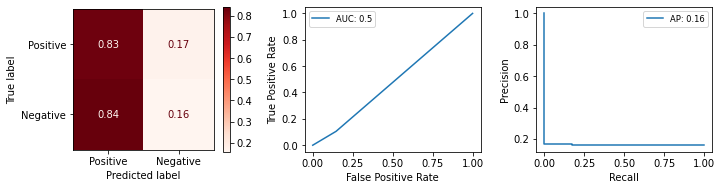

In [22]:
# Let's make a baseline classifier using the dummy model
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', DummyClassifier(strategy='stratified'))
])

clf_pipe.fit(X_train, y_train)

eval_clf_model(clf_pipe, X_test, y_test, X_train, y_train, 
               labels=class_labels)

##  Testing Freq Options on Multinomial Bayes Models

I'm going to run a few models using a Multinomial Bayes classifier, with minimal processing.

All of the models below are using the preprocessed documents (non-ASCII characters and numbers removed), with Twitter handles removed and lowercasing performed by the TweetTokenizer. 

I'm not removing stopwords or punctuation yet for these baseline models.

I'm also not experimenting with different sizes of n-grams.

The main thing I do want to try to determine is which method of calculating the Document Term Matrix is best for this text. 
Regular `CountVectorizer` with the raw counts, binary count, or TF-IDF normalized. The [sklearn documentation mentions](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):
>"...very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable."

Rather than gridsearch through the different types of vectorizers, which will x3 my computational load and time, I'd prefer to settle on one of these vectorizing options up front and use gridsearch for other parameters and processing options such as n-grams and which stop-words to remove.

In [23]:
# modling pipeline with preprocessing and model built in
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', MultinomialNB())
])

### Tfidf Standardized Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2382
           1       1.00      0.05      0.10       456

    accuracy                           0.85      2838
   macro avg       0.92      0.53      0.51      2838
weighted avg       0.87      0.85      0.79      2838


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       596
           1       1.00      0.02      0.03       114

    accuracy                           0.84       710
   macro avg       0.92      0.51      0.47       710
weighted avg       0.87      0.84      0.77       710


****************************** Training Scores ******************************
            Training Macro F1 = 0.5084
        Training Macro Recall = 0.5263
   Training Balanced Accuracy = 0.5263



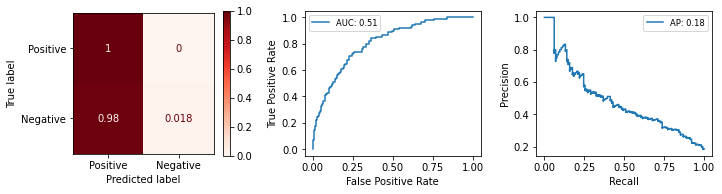

In [24]:
clf_pipe.fit(X_train, y_train)

eval_clf_model(clf_pipe, X_test, y_test, X_train, y_train, labels=class_labels)

These results are actually worse than the dummy classifier; it's just predicting positive for almost everything.

### Counted Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2382
           1       0.91      0.73      0.81       456

    accuracy                           0.94      2838
   macro avg       0.93      0.86      0.89      2838
weighted avg       0.94      0.94      0.94      2838


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       596
           1       0.69      0.24      0.35       114

    accuracy                           0.86       710
   macro avg       0.78      0.61      0.64       710
weighted avg       0.84      0.86      0.83       710


****************************** Training Scores ******************************
            Training Macro F1 = 0.8882
        Training Macro Recall = 0.8571
   Training Balanced Accuracy = 0.8571



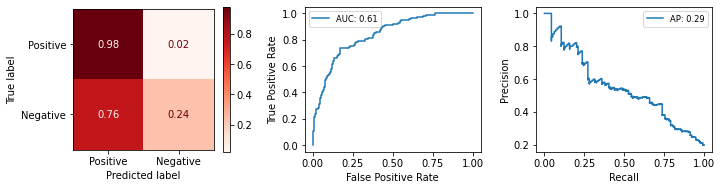

In [25]:
# Since my pipeline includes the Tfidf transformer, I'm explicitly setting
# that pipeline step to be passthrough here to remove it
clf_pipe.set_params(prep__vect__binary=False)
clf_pipe.set_params(prep__trans='passthrough')

clf_pipe.fit(X_train, y_train)

eval_clf_model(clf_pipe, X_test, y_test, X_train, y_train, labels=class_labels)

Better than Tfidf, but still not great on test, with only 32% recall on my target class of Negative.

It's also looking pretty overfit to the training data.

### Binary Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2382
           1       0.92      0.73      0.81       456

    accuracy                           0.95      2838
   macro avg       0.94      0.86      0.89      2838
weighted avg       0.95      0.95      0.94      2838


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.87      0.98      0.93       596
           1       0.75      0.26      0.39       114

    accuracy                           0.87       710
   macro avg       0.81      0.62      0.66       710
weighted avg       0.85      0.87      0.84       710


****************************** Training Scores ******************************
            Training Macro F1 = 0.8912
        Training Macro Recall = 0.8582
   Training Balanced Accuracy = 0.8582



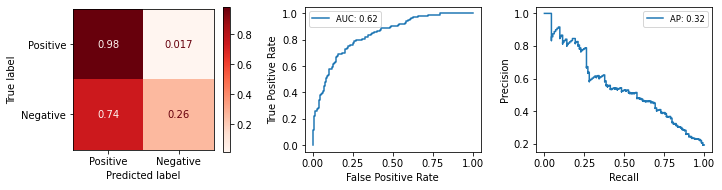

In [26]:
# Let's try the binary representation instead of raw counts
clf_pipe.set_params(prep__vect__binary=True)
clf_pipe.set_params(prep__trans='passthrough')

clf_pipe.fit(X_train, y_train)

eval_clf_model(clf_pipe, X_test, y_test, X_train, y_train, labels=class_labels)

So testing out the different ways I could calculate frequency in the document term matrix, Tfidf performed the poorest on this test where I've done minimal processing (no stopwords or punctuation removal, for instance). The performance difference between binary and count isn't much. 

Initially, I discarded Tfidf frequency based on this test, since it performed so poorly, and ran gridsearches on remaining options on my local machine. However, when I tested lemmatization, I re-introduced the option of Tfidf and it was selected in the best model. Although Tfidf was the worst here, when I started doing more preprocessing on the text (removing stopwords and stemming/lemmatization) it performed better. I realized my decision to discard Tfidf based on this initial test alone was not sound, and I needed to test all the options together to really find the best model.

Since an exhaustive gridsearch with 5-fold CV would be too computationally expensive on my local laptop, I will run it on Google Colab. 

## GridSearchCVs: no stemming or lemmatization

First, I'm going to search through params without applying any stemming or lemmatization, but removing stop words and punctuation.

In [15]:
# set this variable equal to True to re-run the gridsearches
rerun_grid = True

In [16]:
# Params that will apply to the vectorizer regardless of how the
# document term matrix is constructed
common_params = {"prep__vect__stop_words": [custom_stopwords + punc_custom,
            nltk_stopwords + punc_custom,
            product_stopwords + custom_stopwords + punc_custom,
            punc_custom + product_stopwords + nltk_stopwords],
    "prep__vect__ngram_range": [(1,1), (1,2), (2,2)],
    "prep__vect__max_features": [None, 1000]}

# Params for the binary frequency, where we don't want to bother with a Tfidf
binary_params = {
    "prep__vect__binary": [True],
    "prep__trans": ['passthrough']}

# params for non-binary frequency, where we want to test both with and without
# Tfidf
count_params = {
    "prep__vect__binary": [False],
    "prep__trans": [TfidfTransformer(), 'passthrough']}

In [17]:
save_path = "/content/gdrive/My Drive/Data Science/Phase 4 Project/"

In [18]:
def clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                     class_labels, file_name, save_path, 
                     scoring='recall_macro', n_jobs=-1, verbose=True):
    """
    file_name used in exporting best estimator to file
    """
    gs = GridSearchCV(clf_pipe, grid_params, n_jobs=n_jobs, verbose=verbose,
                         scoring=scoring)

    # run the gridsearch
    gs.fit(X_train, y_train)

    # print best estimator params and score
    print(gs.best_estimator_)
    print(gs.best_score_)

    # dump out best estimator and gs object to gdrive
    joblib.dump(gs.best_estimator_.named_steps['clf'], 
                f"{save_path}BestEst_{file_name}.joblib.gz")
    print()
    print(f"Saved best estimator to: {save_path}BestEst_{file_name}.joblib.gz")
    joblib.dump(gs, f"{save_path}GSObject_{file_name}.joblib.gz")
    print()
    print(f"Saved GridSearch object to: {save_path}GSObject_{file_name}.joblib.gz")

    # print the classifier model report
    eval_clf_model(gs, X_test, y_test, X_train, y_train, labels=class_labels)

    return None


### Multinomial Bayes

In [ ]:
# Add Multinomial Bayes as the classifier model
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', MultinomialNB())
])

# classifier-specific params for MNB
clf_params = {"clf__fit_prior": [True, False]}

# create grid params for MNB
grid_params = [{**common_params, **binary_params, **clf_params},
               {**common_params, **count_params, **clf_params}]

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  3.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['2'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('prep',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  CountVectorizer(analyzer='word', binary=True,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=1000, min_df=1,
                                                  ngram_range=(1, 1),
                                                  preprocessor=None,
                                                  stop_words=['google', 'apple',
                                                              'ipad', 'iphone',
                                                

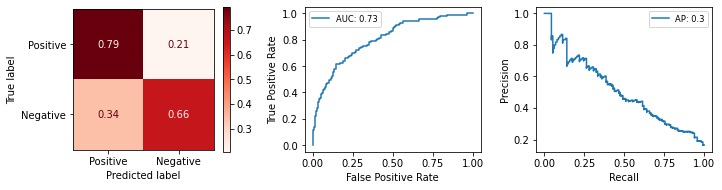

In [ ]:
model_name = "MNB_binary_nostemlem"
clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                     class_labels, file_name=model_name, save_path=save_path, 
                     scoring='recall_macro')

In [ ]:
# test reloading the best estimator back in
test = joblib.load(f"{save_path}BestEst_MNB_binary_nostemlem.joblib.gz")
test.coef_[0][:5]

array([-4.50575902, -8.49474306, -8.49474306, -8.49474306, -6.88530515])

### Random Forest

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 19.5min finished


Pipeline(memory=None,
         steps=[('prep',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  CountVectorizer(analyzer='word', binary=True,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=1000, min_df=1,
                                                  ngram_range=(1, 1),
                                                  preprocessor=None,
                                                  stop_words=['a', 'an', 'and',
                                                              'am', 'are', 'as',
                                                

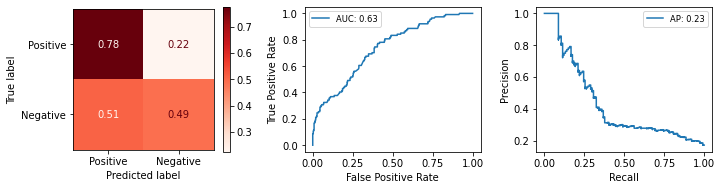

In [ ]:
# Subbing Random Forest for the classifier
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

# classifier-specific params for RF
clf_params = {"clf__criterion": ['gini', 'entropy'],
    "clf__max_depth": [5, 10, 50]}

# create grid params for RF
grid_params = [{**common_params, **binary_params, **clf_params},
               {**common_params, **count_params, **clf_params}]

model_name = "RF_binary_nostemlem"

# run gridsearch for RF
clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                     class_labels, file_name=model_name, save_path=save_path, 
                     scoring='recall_macro')

### Logistic Regression

In [1]:
# Subbing Logistic Regression for the classifier
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

# classifier-specific params for LR
clf_params = {"clf__penalty": ['l1', 'l2', 'elasticnet'],
    "clf__fit_intercept": [True, False],
    "clf__solver": ['newton-cg', 'lbfgs', 'saga'],
    "clf__C": [1, 0.1]}

# create grid params for LR
grid_params = [{**common_params, **binary_params, **clf_params},
               {**common_params, **count_params, **clf_params}]

model_name = "LR_binary_nostemlem"

# run gridsearch for RF
clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                     class_labels, file_name=model_name, save_path=save_path, 
                     scoring='recall_macro')

NameError: ignored

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Pipeline(memory=None,
         steps=[('prep',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  CountVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=None, min_df=1,
                                                  ngram_range=(1, 1),
                                                  preprocessor=None,
                                                  stop_words=['a', 'about',
                                                              'above', 'after',
                                                    

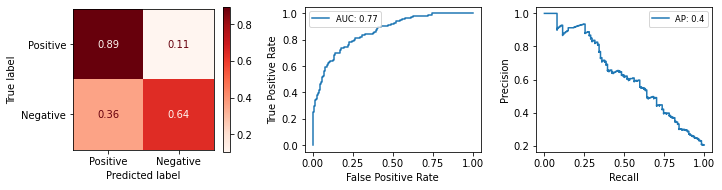

In [36]:
# Rerunning because got the best params printed, but lost the gs object due to an 
# error saving to file
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize, 
                stop_words=nltk_stopwords + punc_custom, binary=False,
                ngram_range=(1,1))),
    ('trans', TfidfTransformer())
])

clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

# classifier-specific params for LR
clf_params = {"clf__penalty": ['l2'],
    "clf__fit_intercept": [False],
    "clf__solver": ['newton-cg'],
    "clf__C": [1]}

model_name = "LR_binary_nostemlem"

# run gridsearch for RF
clf_gridsearch_wpipe(clf_pipe, clf_params, X_train, y_train, X_test, y_test,
                     class_labels, file_name=model_name, save_path=save_path, 
                     scoring='recall_macro')

In [ ]:
joblib.dump(gs.best_estimator_.named_steps['clf'], 
            f"{save_path}BestEst_{file_name}.joblib.gz")
print()
print(f"Saved best estimator to: {save_path}BestEst_{file_name}.joblib.gz")
joblib.dump(gs, f"{save_path}GSObject_{file_name}.joblib.gz")
print()
print(f"Saved GridSearch object to: {save_path}GSObject_{file_name}.joblib.gz")

# print the classifier model report
eval_clf_model(gs, X_test, y_test, X_train, y_train, labels=class_labels)

Pipeline(memory=None,
         steps=[('prep',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  CountVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=1000, min_df=1,
                                                  ngram_range=(1, 1),
                                                  preprocessor=None,
                                                  stop_words=['a', 'an', 'and',
                                                              'am', 'are', 'as',
                                               

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["it'"] not in stop_words.
  'stop_words.' % sorted(inconsistent))


****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      2382
           1       0.58      0.94      0.72       456

    accuracy                           0.88      2838
   macro avg       0.78      0.91      0.82      2838
weighted avg       0.92      0.88      0.89      2838


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       596
           1       0.48      0.72      0.57       114

    accuracy                           0.83       710
   macro avg       0.71      0.78      0.73       710
weighted avg       0.87      0.83      0.84       710


****************************** Training Scores ******************************
            Training Macro F1 = 0.8222
        Training Macro Recall = 0.9057
   Training Balanced Accuracy = 0.9057



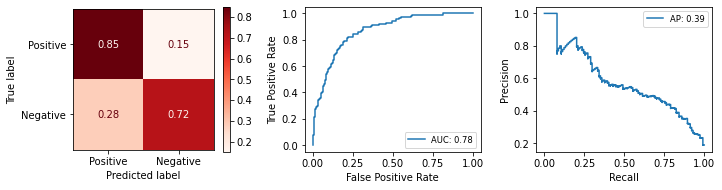

In [ ]:
# test reloading the best estimator back in
best_lr_bin_nostem = joblib.load(f"{save_path}BestEst_LR_binary_nostemlem.joblib.gz")
gs_lr_bin_nostem = joblib.load(f"{save_path}GSObject_LR_binary_nostemlem.joblib.gz")

print(gs_lr_bin_nostem.best_estimator_)
print(gs_lr_bin_nostem.best_score_)

eval_clf_model(gs_lr_bin_nostem, X_test, y_test, X_train, y_train, labels=class_labels)

## Try out some stemming and lemmatization

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
stemmer = PorterStemmer()
stemmer.stem('testing')

'test'

In [ ]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize("testing")

'testing'

In [ ]:
lemmatizer.lemmatize("feet")

'foot'

Hmm, so the lemmatizer is not doing the best job here even with a simple word like `testing`. Stemming did much better with that.

Maybe I'll try passing through lemmatizer first (which will leave words it can't do anything with alone, but change what it can) and then do stemming separately.

In [ ]:
def tokenize_lemma_stem(doc):
    """
    Applies TweetTokenization, then lemmatization and stemming in one shot.
    
    Uses NLTK, so assumes the appropriate NLTK classes have been imported.
    
    Uses TweetTokenizer to tokenize documents first, and remove handles.
    Then uses NLTK lemmatization on each token.
    Finally, applies stemming to each token.
    """
    tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    # tokenize using TweetTokenizer
    tokens = tweettokenizer.tokenize(doc)
    
    # lemmatize using NLTK
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # stem using NLTK
    tokens = [stemmer.stem(token, ) for token in tokens]
    
    return tokens

Let's test it out!

In [ ]:
tokenize_lemma_stem("This isn't what I was hoping for. I'm testing. Feet and hands. What do you think? Thinking?")

['thi',
 "isn't",
 'what',
 'i',
 'wa',
 'hope',
 'for',
 '.',
 "i'm",
 'test',
 '.',
 'foot',
 'and',
 'hand',
 '.',
 'what',
 'do',
 'you',
 'think',
 '?',
 'think',
 '?']

### Multinomial Bayes

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 17.4min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', "it'", 'onc', 'onli', 'ourselv', "she'", "should'v", 'themselv', 'thi', 'veri', 'wa', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('prep',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  CountVectorizer(analyzer='word', binary=True,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.int64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=1000, min_df=1,
                                                  ngram_range=(1, 1),
                                                  preprocessor=None,
                                                  stop_words=['a', 'about',
                                                              'above', 'after',
                                                     

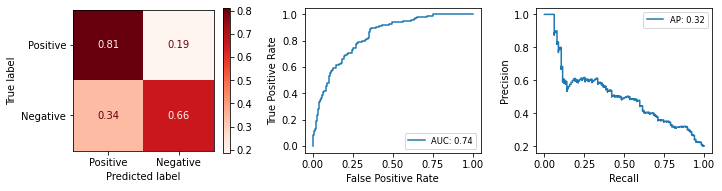

In [ ]:
# pre-processing pipeline using stemming and lemmatization
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize_lemma_stem)),
    ('trans', TfidfTransformer())
])

# main pipeline with clf
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', MultinomialNB())
])

# classifier-specific params for MNB
clf_params = {"clf__fit_prior": [True, False]}

# create grid params for MNB
grid_params = [{**common_params, **binary_params, **clf_params},
               {**common_params, **count_params, **clf_params}]

model_name = "MNB_binary_withstemlem"

# run gridsearch for MNB
clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                     class_labels, file_name=model_name, save_path=save_path, 
                     scoring='recall_macro')

### Logistic Regression

In [ ]:
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

# classifier-specific params for LR
clf_params = {"clf__penalty": ['l1', 'l2', 'elasticnet'],
    "clf__fit_intercept": [True, False],
    "clf__solver": ['newton-cg', 'lbfgs', 'saga'],
    "clf__C": [1, 0.1]}

# create grid params for LR
grid_params = [{**common_params, **binary_params, **clf_params},
               {**common_params, **count_params, **clf_params}]

model_name = "LR_binary_withstemlem"

# run gridsearch for LR
clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                     class_labels, file_name=model_name, save_path=save_path, 
                     scoring='recall_macro')

# Modeling Multi-class

Initially, I built models to parse out the positive or negative product sentiment, to understand what people said that contributed to each one.

To really make this useful though, we would want to be able to pull tweets from another year, for example, and classify which were actually about these products and which weren't.

In [ ]:
df['emotion'].value_counts()

In [ ]:
Xm = df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion',
                              'No emotion toward brand or product']), 
           'cleaned']
ym = df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion',
                              'No emotion toward brand or product']), 
           'emotion']

print(len(Xm))
print(len(ym))

8936
8936


In [ ]:
ym = ym.map(lambda x: 0 if x=="Negative emotion" else \
            (1 if x=="No emotion toward brand or product" else 2))
ym.value_counts()

1    5388
2    2978
0     570
Name: emotion, dtype: int64

In [ ]:
# 0 is negative, 1 is none, 2 is positive
mclass_labels = ['Negative', 'None', 'Positive']

In [ ]:
# train test split
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2,
                                               stratify=ym)
print(len(Xm_train))
print(len(ym_train))
print(len(Xm_test))
print(len(ym_test))

7148
7148
1788
1788


In [ ]:
ym_train.value_counts(normalize=True)

1    0.602966
2    0.333240
0    0.063794
Name: emotion, dtype: float64

In [ ]:
ym_test.value_counts(normalize=True)

1    0.602908
2    0.333333
0    0.063758
Name: emotion, dtype: float64

## Dummy Classifier for Multiclass


****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.07      0.07      0.07       456
           1       0.60      0.60      0.60      4310
           2       0.35      0.35      0.35      2382

    accuracy                           0.48      7148
   macro avg       0.34      0.34      0.34      7148
weighted avg       0.49      0.48      0.48      7148


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.02      0.02      0.02       114
           1       0.59      0.60      0.59      1078
           2       0.32      0.32      0.32       596

    accuracy                           0.47      1788
   macro avg       0.31      0.31      0.31      1788
weighted avg       0.47      0.47      0.47      1788


****************************** Training Scores ******************************
          

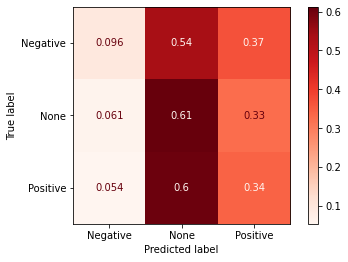

In [ ]:
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('trans', TfidfTransformer())
])

# modling pipeline with preprocessing and model built in
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', DummyClassifier(strategy='stratified'))
])

clf_pipe.fit(Xm_train, ym_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xm_train, ym_train, 
               labels=mclass_labels)

## Baseline Multinomial Bayes Models

In [ ]:
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', MultinomialNB())
])

### Tfidf Standardized Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.86      0.01      0.03       456
           1       0.70      0.99      0.82      4310
           2       0.92      0.39      0.54      2382

    accuracy                           0.73      7148
   macro avg       0.82      0.46      0.46      7148
weighted avg       0.78      0.73      0.68      7148


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       114
           1       0.64      0.97      0.77      1078
           2       0.68      0.18      0.29       596

    accuracy                           0.64      1788
   macro avg       0.77      0.39      0.36      1788
weighted avg       0.68      0.64      0.56      1788


****************************** Training Scores ******************************
          

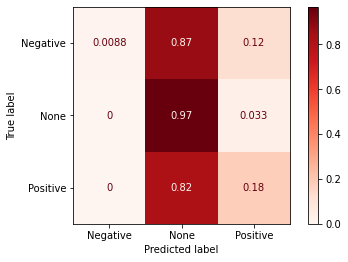

In [ ]:
clf_pipe.fit(Xm_train, ym_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xm_train, ym_train, 
               labels=mclass_labels)

Well that's definitely worse than the dummy.

### Counted Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.85      0.44      0.58       456
           1       0.84      0.89      0.87      4310
           2       0.77      0.75      0.76      2382

    accuracy                           0.82      7148
   macro avg       0.82      0.69      0.74      7148
weighted avg       0.82      0.82      0.81      7148


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.55      0.15      0.23       114
           1       0.72      0.78      0.75      1078
           2       0.54      0.54      0.54       596

    accuracy                           0.66      1788
   macro avg       0.61      0.49      0.51      1788
weighted avg       0.65      0.66      0.65      1788


****************************** Training Scores ******************************
          

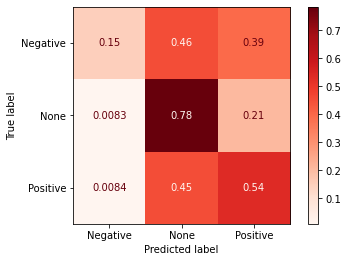

In [ ]:
# Since my pipeline includes the Tfidf transformer, I'm explicitly setting
# that pipeline step to be passthrough here to remove it
clf_pipe.set_params(prep__vect__binary=False)
clf_pipe.set_params(prep__trans='passthrough')

clf_pipe.fit(Xm_train, ym_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xm_train, ym_train, 
               labels=mclass_labels)

Not bad on the None class, but we're only classifying 19% of Negatives correctly and 56% of positives correctly.

### Binary Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.86      0.43      0.57       456
           1       0.84      0.90      0.87      4310
           2       0.78      0.75      0.77      2382

    accuracy                           0.82      7148
   macro avg       0.83      0.70      0.74      7148
weighted avg       0.82      0.82      0.82      7148


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.56      0.16      0.25       114
           1       0.72      0.80      0.76      1078
           2       0.55      0.52      0.53       596

    accuracy                           0.66      1788
   macro avg       0.61      0.49      0.51      1788
weighted avg       0.65      0.66      0.65      1788


****************************** Training Scores ******************************
          

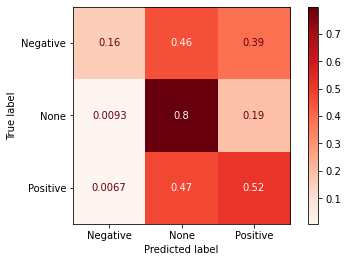

In [ ]:
# Let's try the binary representation instead of raw counts
clf_pipe.set_params(prep__vect__binary=True)
clf_pipe.set_params(prep__trans='passthrough')

clf_pipe.fit(Xm_train, ym_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xm_train, ym_train, 
               labels=mclass_labels)

Pretty similar performance in terms of which method of creating the term document matrix is best. Tfidf is worst.

## GridSearchCVs for best params for various models

In [ ]:
# set this variable equal to True to re-run the gridsearches
rerun_grid = True

### Logistic Regression

In [ ]:
# pre-processing pipeline with NO stemming or lemmatization
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('trans', TfidfTransformer())
])

clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

# create a dict of params for LR
clf_params = {"clf__penalty": ['l1', 'l2', 'elasticnet'],
    "clf__fit_intercept": [True, False],
    "clf__solver": ['newton-cg', 'lbfgs', 'saga'],
    "clf__C": [1, 0.1]}

# create grid params for LR
grid_params = [{**common_params, **binary_params, **clf_params},
               {**common_params, **count_params, **clf_params}]

model_name = "LR_multiclass_nostemlem"

# run gridsearch for LR
clf_gridsearch_wpipe(clf_pipe, grid_params, Xm_train, ym_train, Xm_test, ym_test,
                     mclass_labels, file_name=model_name, save_path=save_path, 
                     scoring='recall_macro')

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 55.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 112.9min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 119.8min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 132.8min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 146.7min


In [ ]:
if rerun_grid:
    gsm_lr = GridSearchCV(clf_pipe, grid_params, n_jobs=-1, verbose=True,
                         scoring='f1_macro')

    gsm_lr.fit(Xm_train, ym_train)

    print(gsm_lr.best_estimator_)
    print(gsm_lr.best_score_)

    eval_clf_model(gsm_lr, Xm_test, ym_test, Xm_train, ym_train, 
                   labels=mclass_labels)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 41.2min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 45.9min finished
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('prep',
                 Pipeline(steps=[('vect',
                                  CountVectorizer(binary=True,
                                                  stop_words=['a', 'about',
                                                              'above', 'after',
                                                              'again',
                                                              'against', 'ain',
                                                              'all', 'am', 'an',
                                                              'and', 'any',
                                                              'are', 'aren',
                                                              "aren't", 'as',
                                                              'at', 'be',
                                                              'because', 'been',
                                                              'before', 'being',
               

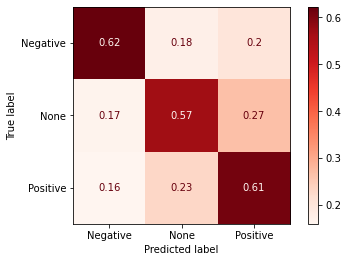

In [ ]:
# Let's try optimizing for recall and see if we get any better results?
if rerun_grid:
    gsm_lr = GridSearchCV(clf_pipe, grid_params, n_jobs=-1, verbose=True,
                         scoring='recall_macro')

    gsm_lr.fit(Xm_train, ym_train)

    print(gsm_lr.best_estimator_)
    print(gsm_lr.best_score_)

    eval_clf_model(gsm_lr, Xm_test, ym_test, Xm_train, ym_train, 
                   labels=mclass_labels)